# Use Double Q Learning to Play Taxi-v3

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

imp.reload(logging)
logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Taxi-v3')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

21:04:49 [INFO] env: <TaxiEnv<Taxi-v3>>
21:04:49 [INFO] action_space: Discrete(6)
21:04:49 [INFO] observation_space: Discrete(500)
21:04:49 [INFO] reward_range: (-inf, inf)
21:04:49 [INFO] metadata: {'render.modes': ['human', 'ansi']}
21:04:49 [INFO] _max_episode_steps: 200
21:04:49 [INFO] _elapsed_steps: None


In [3]:
class DoubleQLearningAgent:
    def __init__(self, env):
        self.gamma = 0.99
        self.learning_rate = 0.1
        self.epsilon = 0.01
        self.action_n = env.action_space.n
        self.qs = [np.zeros((env.observation_space.n, env.action_space.n)) for _ in range(2)]

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.uniform() < self.epsilon:
            action = np.random.randint(self.action_n)
        else:
            action = (self.qs[0] + self.qs[1])[observation].argmax()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        state, _, _, action, next_state, reward, done, _ = \
                        self.trajectory[-8:]

        if np.random.randint(2):
            self.qs = self.qs[::-1] # swap two elements
        a = self.qs[0][next_state].argmax()
        v = reward + self.gamma * self.qs[1][next_state, a] * (1. - done)
        target = reward + self.gamma * v * (1. - done)
        td_error = target - self.qs[0][state, action]
        self.qs[0][state, action] += self.learning_rate * td_error


agent = DoubleQLearningAgent(env)

21:04:50 [INFO] ==== train ====
21:05:03 [INFO] ==== test ====
21:05:03 [INFO] average episode reward = 7.84 ± 2.32


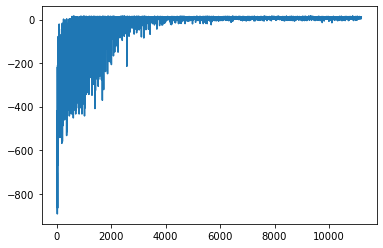

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-200:]) > 8:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()